In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
plt.style.use('ggplot')

In [8]:
df_text = pd.read_csv('../data/training_text.csv',delimiter='\|\|',index_col=0)
df_variants = pd.read_csv('../data/training_variants.csv',index_col=0)
df_variants.head()

/home/z/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


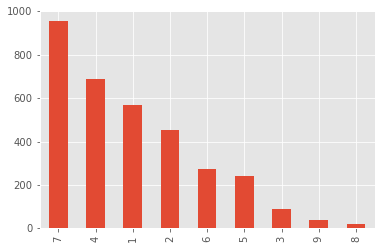

In [9]:
df_variants.Class.value_counts().plot(kind='bar',)

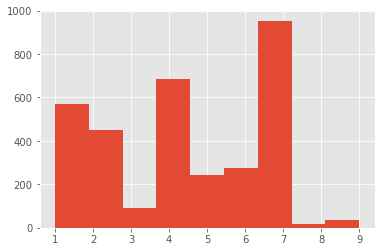

In [10]:
df_variants.Class.hist(bins=9)